### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import gensim
from wordcloud import WordCloud

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['sxsw', 'link', 'mention'])

tokenizer = nltk.tokenize.TweetTokenizer()

[nltk_data] Downloading package punkt to /home/hritik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hritik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading Data

In [3]:
train = pd.read_excel("../data/dataset.xlsx", sheet_name = "Train")
test = pd.read_excel("../data/dataset.xlsx", sheet_name = "Test")

### Preprocessing Data

In [4]:
train = train.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'entity', # entity means brand, product or service
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
})

In [5]:
import numpy as np
train.emotion.value_counts(dropna=False).to_dict()

{'No emotion toward brand or product': 5389,
 'Positive emotion': 2672,
 'Negative emotion': 519,
 "I can't tell": 9}

In [6]:
train.entity.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

##### - "tweet" column

Removing mentions and hashtags can be removed but no need it might contains mentions and hashtags related to the brand, product or service.
Removing extra ascii characters

In [7]:
train = train[train["tweet"].notna()].reset_index(drop = True)

In [8]:
train["tweet"] = train["tweet"].str.replace(pat = r'[^a-zA-Z0-9#@\!$%^&*(){}:\-\'\":;,\.?/\s]', repl = ' ', regex=True)
train["tweet"] = train["tweet"].str.replace(pat = r'[:;,\.?/\s]{2,}', repl = ' ', regex= True)
train["tweet"] = train["tweet"].str.strip()

##### - "entity" column

In [9]:
train.entity.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

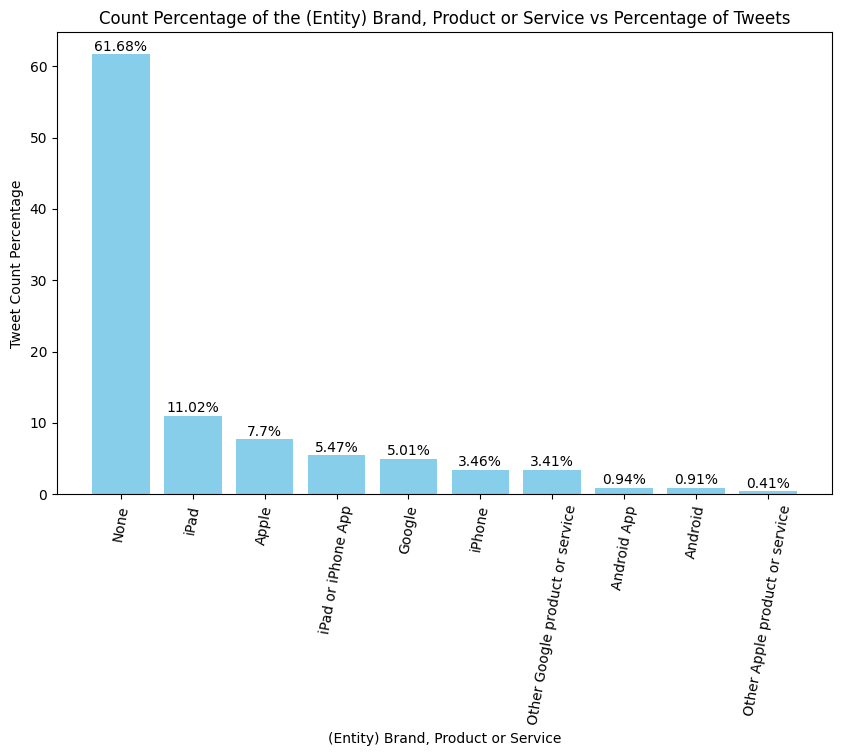

In [10]:
train["entity"].fillna("None", inplace=True)
value_counts = train.entity.value_counts()

# Create a bar chart with labels on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts/len(train)*100, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(round(yval, 2)) + "%", ha='center', va='bottom')

plt.title('Count Percentage of the (Entity) Brand, Product or Service vs Percentage of Tweets')
plt.xlabel('(Entity) Brand, Product or Service')
plt.ylabel('Tweet Count Percentage')
plt.xticks(rotation=80, ha='center')  # Rotate x-axis labels for better readability
plt.show()

##### - "emotion" column

In [11]:
train["emotion"].replace({
    "No emotion toward brand or product" : "No emotion",
    "I can't tell": "Don't Know"
}, inplace=True)

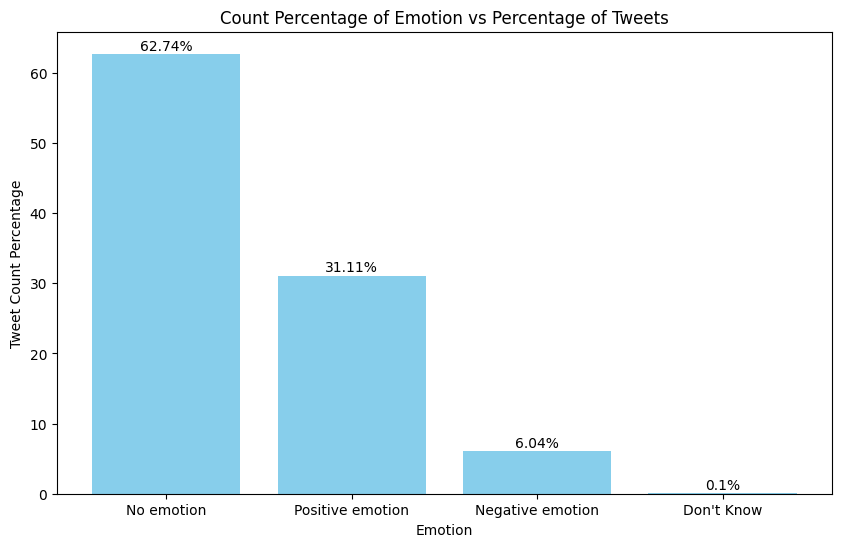

In [12]:
value_counts = train.emotion.value_counts(dropna=False)

# Create a bar chart with labels on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts/len(train)*100, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(round(yval, 2)) + "%", ha='center', va='bottom')

plt.title('Count Percentage of Emotion vs Percentage of Tweets')
plt.xlabel('Emotion')
plt.ylabel('Tweet Count Percentage')
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
plt.show()

##### "brands" Columns

In [13]:
brand_groups = {
    'iPhone': 'Apple',
    'iPad or iPhone App' : 'Apple',
    'iPad': 'Apple',
    'Other Apple product or service': 'Apple',
    'Android': 'Google',
    'Android App': 'Google',
    'Other Google product or service': 'Google',
}

In [14]:
train["brand"] = train["entity"].replace(to_replace=brand_groups)

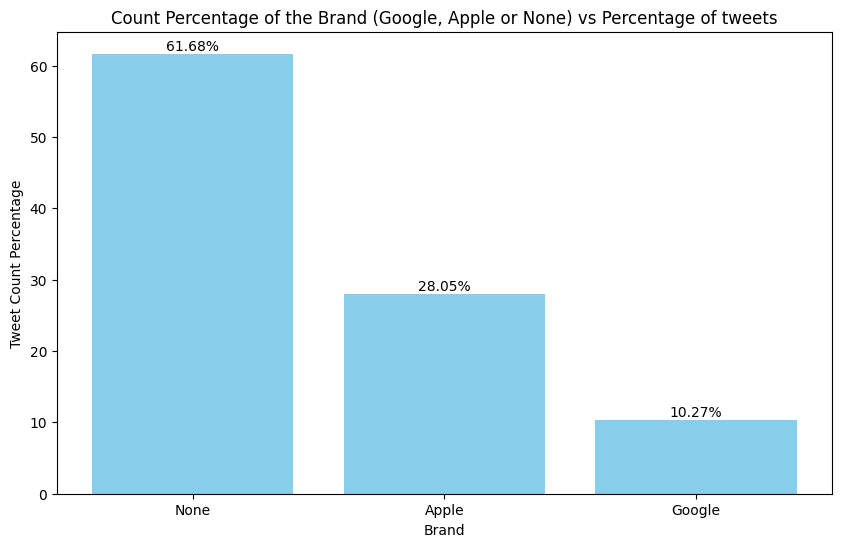

In [15]:
value_counts = train.brand.value_counts()

# Create a bar chart with labels on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts/len(train)*100, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(round(yval, 2)) + "%", ha='center', va='bottom')

plt.title('Count Percentage of the Brand (Google, Apple or None) vs Percentage of tweets')
plt.xlabel('Brand')
plt.ylabel('Tweet Count Percentage')
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
plt.show()

##### Percentage of all Emotions divide across brands

In [16]:
groups = train.groupby(by=["brand", "emotion"])
count_groups = groups.size()

In [17]:
count_groups.index.get_level_values("brand").unique()

Index(['Apple', 'Google', 'None'], dtype='object', name='brand')

In [18]:
brand = "Apple"
(count_groups.loc[brand]/count_groups.loc[brand].sum()*100).sort_values(ascending = False)

emotion
Positive emotion    80.904940
Negative emotion    16.106268
No emotion           2.698215
Don't Know           0.290577
dtype: float64

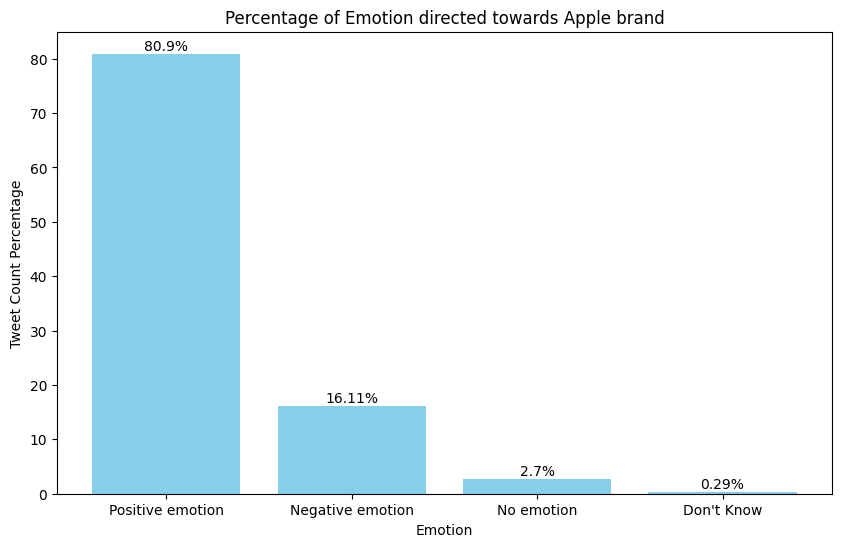

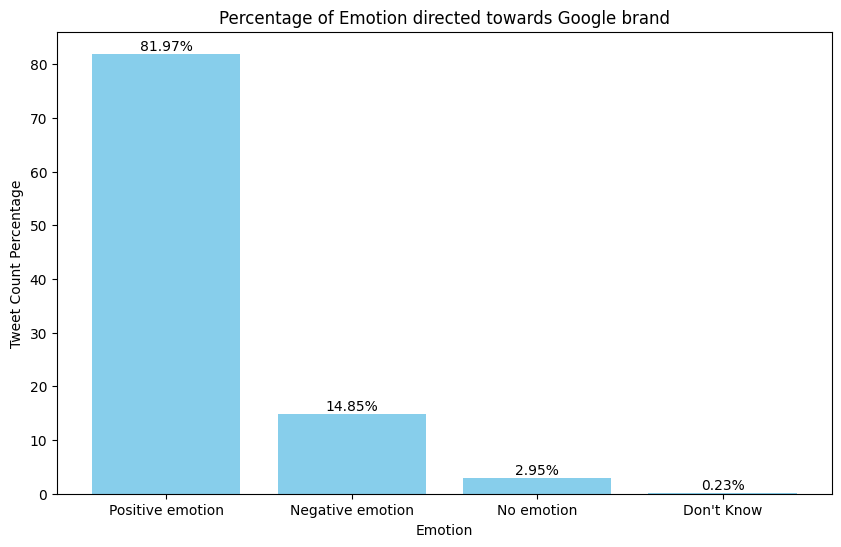

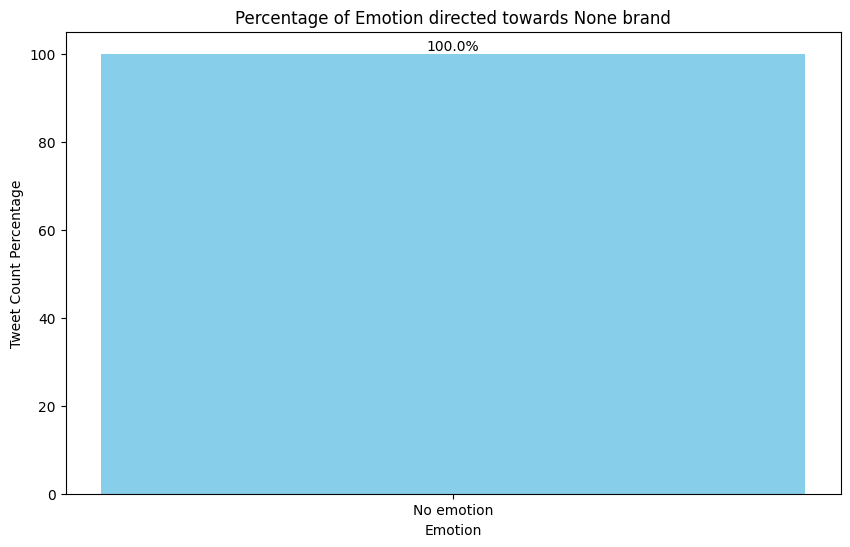

In [19]:
for brand in count_groups.index.get_level_values("brand").unique():
    value_counts = (count_groups.loc[brand]/count_groups.loc[brand].sum()*100).sort_values(ascending = False)
    # Create a bar chart with labels on top of each bar
    plt.figure(figsize=(10, 6))
    bars = plt.bar(value_counts.index, value_counts, color='skyblue')

    # Add labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(round(yval, 2)) + "%", ha='center', va='bottom')

    plt.title(f'Percentage of Emotion directed towards {brand} brand')
    plt.xlabel('Emotion')
    plt.ylabel('Tweet Count Percentage')
    plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for better readability
    plt.show()

##### How many No emotion are common with No Entity (None)

In [20]:
((train["entity"] == "None") & (train["emotion"] == "No emotion")).sum()/(train["emotion"] == "No emotion").sum()

0.9831106161841129

### Topic Modelling

For topic modeling, removed stop words and punctuations from our tweet text

In [21]:
train["tweet_tm"] = train["tweet"].str.replace(pat = r'[^a-zA-Z\s]', repl = ' ', regex=True)
train["tweet_tm"] = train["tweet_tm"].str.replace(pat = r'\s{2,}', repl = ' ', regex= True)
train["tweet_tm"] = train["tweet_tm"].str.strip().str.lower()

In [22]:
data_ready = []
for tweet in tokenizer.tokenize_sents(train["tweet_tm"].to_list()):
    data_ready.append([word for word in tweet if word not in stop_words])

In [23]:
id2word = gensim.corpora.Dictionary(documents= data_ready)

In [24]:
corpus = [id2word.doc2bow(text) for text in data_ready]

Choosing only two number of topics after going throught the datasets as the tweets are distributed among the entities Google, Apple

In [25]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=2, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=250,
                                            per_word_topics=True)

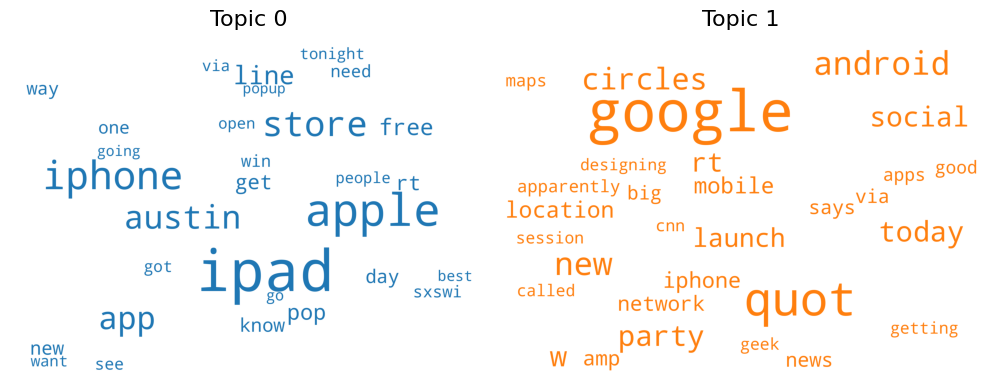

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords= stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words= 50)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
